# <center>Final Project; Algorithms in Modern Statistics </center>
**Submitted by**: 
**<center>Full Names: Matan Mizrachi, Eyal Stolov</center>**

The following project is fully based on the data, that could be found and explained [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students).

You might also need to run the next block (not as comments).

In [1]:
#!pip install plotly-express
#!pip install tqdm
#!pip install bayesian-optimization
#!pip install shap

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix


from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, f_oneway

from itertools import combinations, permutations

from bayes_opt import BayesianOptimization
import shap


from typing import Union
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
tqdm.pandas()

## Useful Functions

### Plottings

In [3]:
def plot_decomposition(est, data: pd.DataFrame, color, dim=2, method='px', hover_data=None, marker=None,
                       exclude_dtypes=None, drop_color=False,
                       drop_columns=None, title='', return_estimator=False):
    _df = data.copy()
    if drop_columns:
        _df = _df.drop(columns=drop_columns)
    if exclude_dtypes:
        _df = _df.select_dtypes(exclude=exclude_dtypes)
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].progress_apply(lambda _z: _z.astype('category').cat.codes)
    color = _df[color].copy() if method == 'plt' else data[color].copy()
    _df = _df.drop(columns = [color.name]) if color.name in _df.columns and drop_color else _df

    est = est.fit(StandardScaler().fit_transform(_df))
    _x = est.transform(StandardScaler().fit_transform(_df))
    
    dim_cols = [f'PC{i} : Most Important - {_df.columns[np.abs(est.components_[i-1]).argmax()]}' for i in range(1, dim+1)]
    _x = pd.DataFrame(_x[:, :dim], columns=dim_cols)
    
    if hover_data:
        if type(hover_data) == str:
            hover_data = [hover_data]
        _x[hover_data] = data[hover_data]
    else:
        hover_data = _df.columns
        _x[hover_data] = data[hover_data]

    _x[color.name] = color
    
    if dim == 2:      
        if method == 'px':
            fig = px.scatter(_x, x=dim_cols[0], y=dim_cols[1], color=color.name, hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            cax = plt.scatter(_x[dim_cols[0]], _x[dim_cols[1]], c=color)
            plt.xlabel(dim_cols[0])
            plt.ylabel(dim_cols[1])

    elif dim == 3:
        if method == 'px':
            fig = px.scatter_3d(_x, x=dim_cols[0], y=dim_cols[1], z=dim_cols[2], color=color.name, 
                                hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            ax = plt.axes(projection='3d')
            cax = ax.scatter(_x[dim_cols[0]], _x[dim_cols[1]], _x[dim_cols[2]], c=color, marker='o')
            plt.xlabel(dim_cols[0])
            plt.ylabel(dim_cols[1])
            ax.set_zlabel(dim_cols[2])
    if method == 'px':
        fig.update_layout(
            title={
                'text': title,
                'x': 0.5,
                'y': 0.95,
                'xanchor': 'center',
                'yanchor': 'top'}, coloraxis_colorbar=dict(yanchor="top", x=-0.25,y=1))
        
        fig.show()
    else:
        plt.title(title)
        plt.colorbar(cax, ticks=np.unique(color))
        plt.show()
    if return_estimator:
        return est
    

def biplot(est, data, method='plt'):
    _df = data.copy()
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].progress_apply(lambda _z: _z.astype('category').cat.codes)
    feature_names = _df.columns
    est = est.fit(StandardScaler().fit_transform(_df))
    loadings = est.components_.T * np.sqrt(est.explained_variance_)
    
    for i, (_x, _y) in enumerate(loadings):
        if method == 'plt':
            plt.annotate(feature_names[i], (0, 0), (_x , _y), arrowprops = {'arrowstyle': '<-', 'color': 'black'})
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

### DataFrame Transformations

In [4]:
def split_xy(data: pd.DataFrame, by: str, x: str = None):
    new_df = []
    for _val in data[by].unique():
        if x is not None:
            new_df.append(data.loc[data[by] == _val, x].copy().reset_index(drop=True))
        else:
            new_df.append(data.loc[data[by] == _val].copy().reset_index(drop=True))
    return new_df

def corr_categorical(data, features):
    _df = data.copy()
    _df[features] = _df[features].progress_apply(lambda _z: _z.astype('category').cat.codes)
    
    return _df[features].corr()

def rank(grades):
    a = grades.quantile(0.8)
    b = grades.quantile(0.6)
    c = grades.quantile(0.4)
    d = grades.quantile(0.2)
    
    new_g = grades.copy()
    new_g[grades >= a] = 'A'
    new_g[(grades >= b) & (grades < a)] = 'B'
    new_g[(grades >= c) & (grades < b)] = 'C'
    new_g[(grades >= d) & (grades < c)] = 'D'
    new_g[grades < d] = 'F'
    
    return new_g

### ML and Optimization

In [5]:
def cohens_d_test(data, target, by, title=None):
    if title is None:
        title = 'results' 
    _x1, _x2 = split_xy(data, by, target)
    n1 = len(_x1)
    n2 = len(_x2)
    _x1 = _x1.to_numpy()
    _x2 = _x2.to_numpy()
    
    def s2(_x):
        denum = len(_x) - 1
        num = np.sum((_x - _x.mean())**2)
        return num / denum
    
    s = np.sqrt(((n1 - 1)*s2(_x1) + (n2-1)*s2(_x2)) / (n1 + n2))
    
    d = abs(_x1.mean() - _x2.mean()) / s
    effects = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large', 'Huge']
    sizes = np.array([0.01, 0.2, 0.5, 0.8, 1.0, 2.0])
    res = [_x1.mean(), _x2.mean(), s, d, effects[np.argmin(np.abs(sizes - d))]]
    for i in range(4):
        res[i] = round(res[i], 2)
    
    return pd.DataFrame(data=np.expand_dims(res, 1), index=['$E[x_1]$', '$E[x_2]$', '$s$', '$d$', 'Effect Size'], columns=[title])
    



def optimize(estimator, data, target, settings: dict, extra_steps: Union[list, tuple] = None,
             cv_params: dict = dict(scoring='f1_macro', cv=5), verbose=2,
             opt_params: dict = dict(n_iter=20),
             max_min='max'):

    """
    :param estimator: a sklearn/xgboost trainable object
    :param data: the training data
    :param target: the training target
    :param settings: the model hyperparameters to be tuned with the optimization
    :param extra_steps: extra pipeline steps, prior to the model being optimized (data transformations)
    :param cv_params: parametrs/settings for the cross-validation (number of cv, scoring etc.)
    :param verbose: verbosity level of the bayesian optimization
    :param opt_params: parametrs/settings for the optimization
    :param max_min: whether the optimization should maximize or minimize the target metric
    :return: a sklearn/xgboost trainable object, set with the optimal parameters found by the optimization
    """

    if extra_steps is not None:
        if type(extra_steps) == tuple:
            extra_steps = [extra_steps]

    else:
        extra_steps = []

    def parse_parameter(_p, val):
        if 'dtype' not in settings[_p].keys():
            return val
        dtype = settings[_p]['dtype']
        if dtype in [float, int]:
            val = dtype(val)
            if 'f' in settings[_p].keys():
                return settings[_p]['f'](val)
            return val
        else:
            n = len(settings[_p]['space'])
            val = int(val)
            if val > n - 1:
                return settings[_p]['space'][-1]
            elif val < 0:
                return settings[_p]['space'][0]
            else:
                return settings[_p]['space'][val]

    def get_model(**params):
        for _p, val in params.items():
            params[_p] = parse_parameter(_p, val)

        model = estimator(**params)
        steps = extra_steps.copy()
        steps.append(('final_model', model))
        return Pipeline(steps=steps)

    def cv_model(**params):
        if max_min is 'max':
            cval = cross_val_score(get_model(**params), data, target, **cv_params, error_score=0).mean()
        else:
            cval = - cross_val_score(get_model(**params), data, target, **cv_params, error_score=1e+6).mean()
        return cval

    pbounds = {}
    for k in settings.keys():
        if type(settings[k]['space']) == tuple:
            pbounds[k] = settings[k]['space']
        else:
            pbounds[k] = (0, len(settings[k]['space']))

    optimizer = BayesianOptimization(
        f=cv_model,
        pbounds=pbounds,
        verbose=verbose
    )

    optimizer.maximize(**opt_params)
    print("Final result:", optimizer.max)

    return get_model(**optimizer.max['params'])

## The beginning of the Project

In [6]:
df = pd.read_csv('archive/test_scores.csv')
df['lunch'] = df['lunch'].apply(lambda _z: _z if _z == 'Does not qualify' else 'Qualifies')
df.head()

school school_setting school_type classroom teaching_method  n_student  \
0  ANKYI          Urban  Non-public       6OL        Standard       20.0   
1  ANKYI          Urban  Non-public       6OL        Standard       20.0   
2  ANKYI          Urban  Non-public       6OL        Standard       20.0   
3  ANKYI          Urban  Non-public       6OL        Standard       20.0   
4  ANKYI          Urban  Non-public       6OL        Standard       20.0   

  student_id  gender             lunch  pretest  posttest  
0      2FHT3  Female  Does not qualify     62.0      72.0  
1      3JIVH  Female  Does not qualify     66.0      79.0  
2      3XOWE    Male  Does not qualify     64.0      76.0  
3      556O0  Female  Does not qualify     61.0      77.0  
4      74LOE    Male  Does not qualify     64.0      76.0

## Part 1: EDA
The following part contains of:
- Data Visualizations
- General Statistics of Each Feature
- Visualizing Relationships Between Features
- Dimensionality Reduction

### Categorical Data

In [7]:
df.describe(include='object')

school school_setting school_type classroom teaching_method student_id  \
count    2133           2133        2133      2133            2133       2133   
unique     23              3           2        97               2       2133   
top     GOOBU          Urban      Public       18K        Standard      2FHT3   
freq      158            906        1582        31            1373          1   

       gender             lunch  
count    2133              2133  
unique      2                 2  
top      Male  Does not qualify  
freq     1077              1215

Based on the tables above, we can basically dismiss the *student_id* feature, as its variety leads to no valuable information to be gained out of it.

In [8]:
df = df.drop(columns=['student_id'])

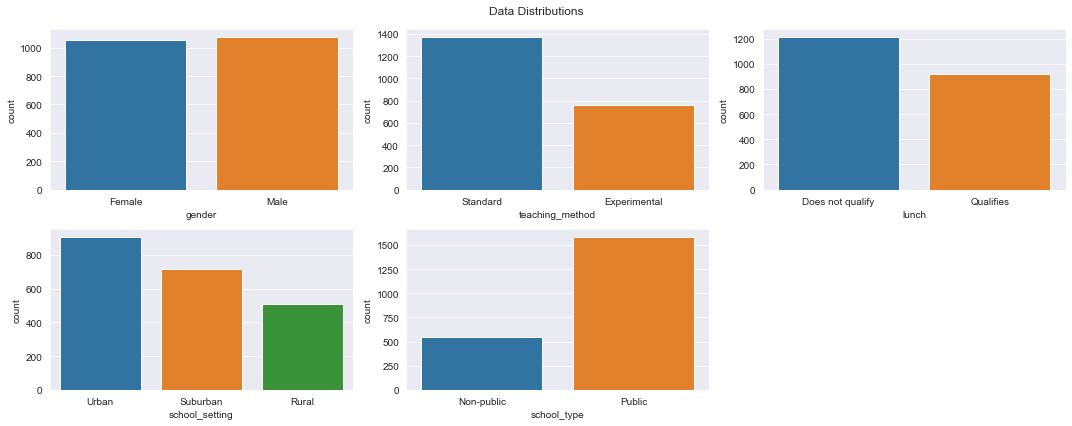

In [9]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[c])
plt.tight_layout()
plt.show()

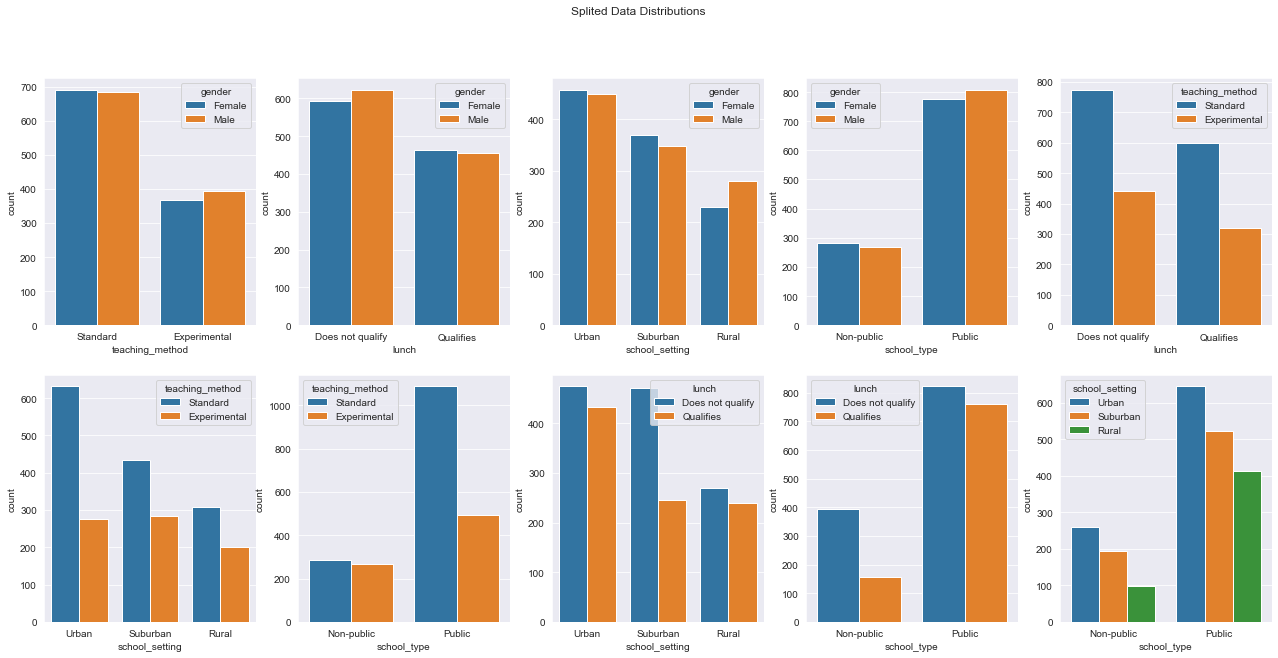

In [10]:
plt.figure(figsize=(22, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
        if j <= i:
            continue
        plt.subplot(2, 5, index)
        index += 1
        sns.countplot(data=df, x=col, hue=hue)
plt.show()

We can already see differences in some of the features distributions when dividing them into separated groups;
- School type, divided by teaching method
- School type, divided by *lunch* feature
- Genders in different school settings

### Numeric Data

In [11]:
df.describe()

n_student      pretest     posttest
count  2133.000000  2133.000000  2133.000000
mean     22.796531    54.955931    67.102203
std       4.228893    13.563101    13.986789
min      14.000000    22.000000    32.000000
25%      20.000000    44.000000    56.000000
50%      22.000000    56.000000    68.000000
75%      27.000000    65.000000    77.000000
max      31.000000    93.000000   100.000000

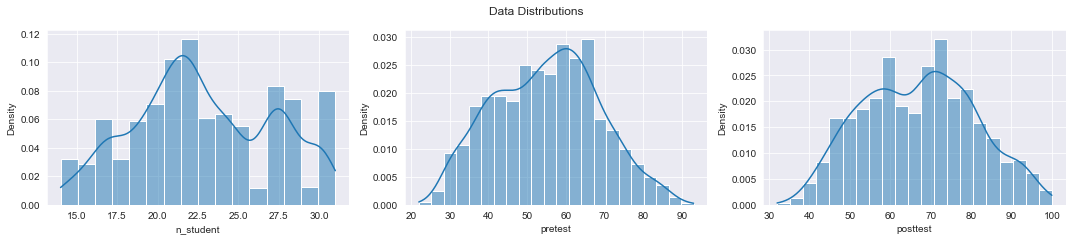

In [12]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['n_student', 'pretest', 'posttest']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=c, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

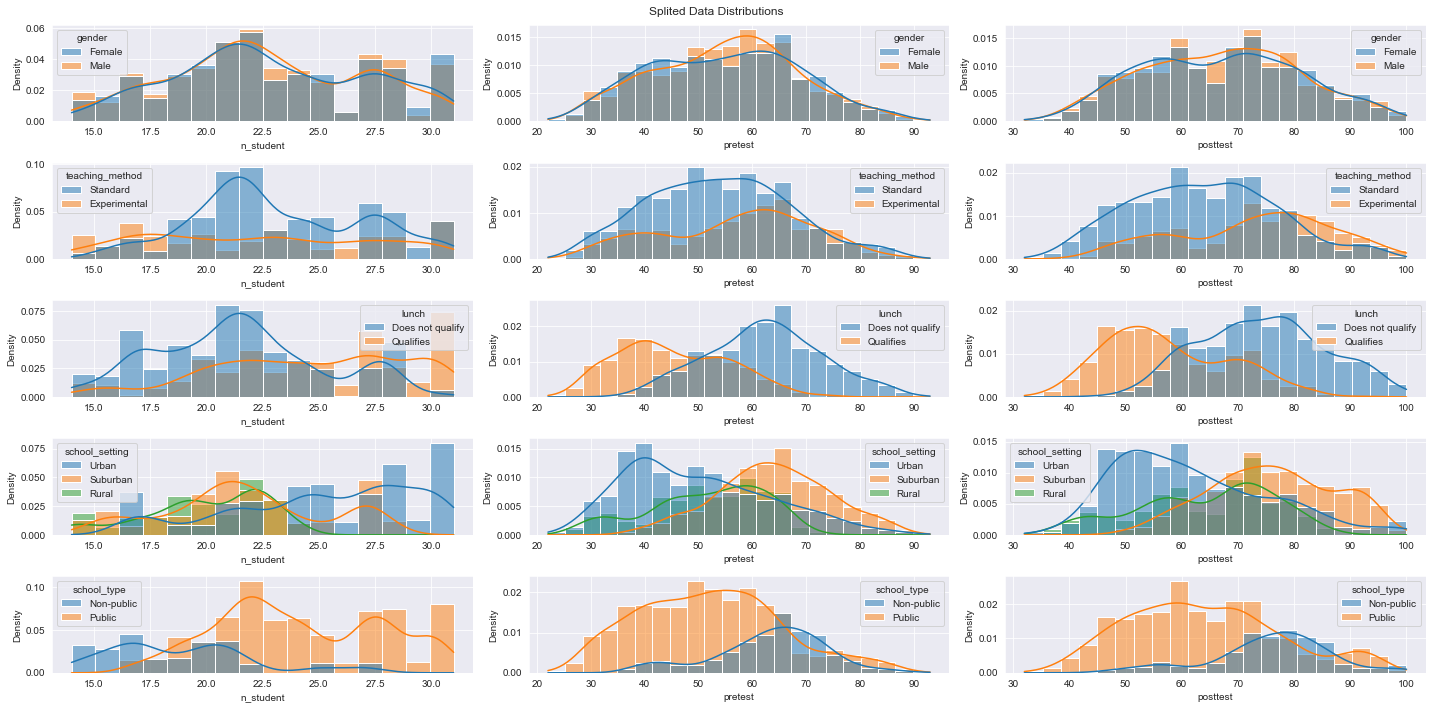

In [13]:
plt.figure(figsize=(20, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['n_student', 'pretest', 'posttest']):
        plt.subplot(5, 3, index)
        index += 1
        sns.histplot(data=df, x=col, hue=hue, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

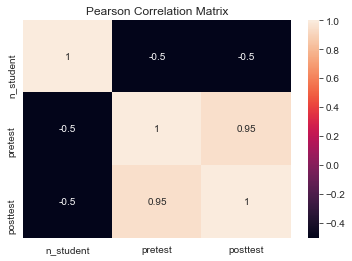

In [14]:
sns.heatmap(df[['n_student', 'pretest', 'posttest']].corr(), annot=True)
plt.title('Pearson Correlation Matrix')
plt.show()

Clearly, the pretest and posttest scores are very highly correlated, almost as if these were the same features to work with.


In [15]:
df = df.drop(columns=['pretest'])

Another interesting thing to investigate is whether the number of students in a class affects, significantly, the class GPA.

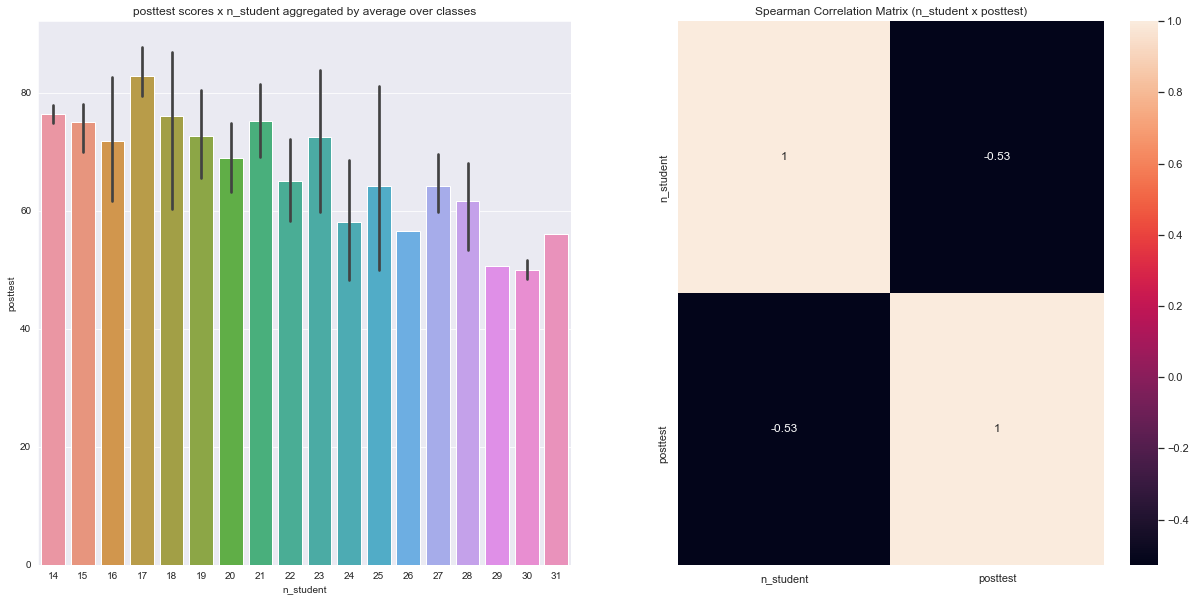

In [16]:
plt.figure(figsize=(21, 10))
plt.subplot(1, 2, 1)
plt.title('posttest scores x n_student aggregated by average over classes')
t_df = df.groupby('classroom').mean()
t_df['n_student'] = t_df['n_student'].astype(int)
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.barplot(data=t_df,x='n_student',y='posttest')

plt.subplot(1, 2, 2)
plt.title('Spearman Correlation Matrix (n_student x posttest)')
sns.heatmap(t_df[['n_student', 'posttest']].corr(method='spearman'), annot=True)

plt.show()

t_df = None
del(t_df)

We can see that the GPA of classes with 23 students or less are above 60 (passing grade). However, the spearman correlation coefficient between the two groups seems to be very low. We can have an hypothesis test on whether the difference of GPA between classes of 23 and less students is significant of class with 24 and more students.

Next, we'd like to see the distributions of posttest grades variances within classrooms and schools, in order to understand whether this features are biased.

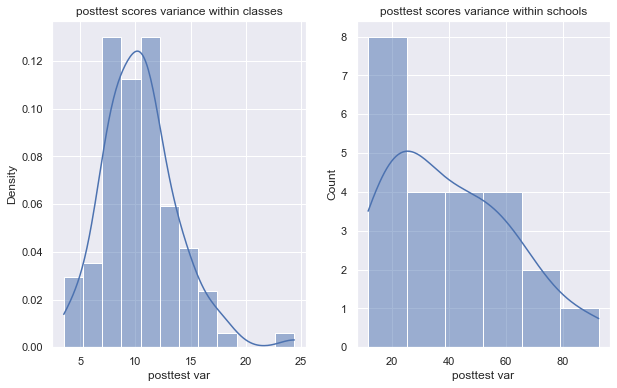

In [17]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('posttest scores variance within classes')
t_df = df.groupby('classroom').var()
sns.histplot(data=t_df, x='posttest', kde=True, stat='density', ax=plt.gca())
plt.xlabel('posttest var')
plt.subplot(1, 2, 2)
plt.title('posttest scores variance within schools')
t_df = df.groupby('school').var()
sns.histplot(data=t_df, x='posttest', kde=True, ax=plt.gca())
plt.xlabel('posttest var')

plt.show()

t_df = None
del(t_df)

The variance of grades within classes is too low, hence, highly biased, and we'd like to get rid of this feaure further ahead.
However, the variance of grades within schools is mostly fine, so we'll keep it.

In [18]:
df = df.drop(columns=['classroom'])

In [19]:
est = plot_decomposition(est=PCA(n_components=2, svd_solver='full'), data=df, color='school_type', marker='lunch',
                         return_estimator=True, title='PCA over Numeric Data', dim=2,
                         drop_columns=['school'], drop_color=False, exclude_dtypes=None)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

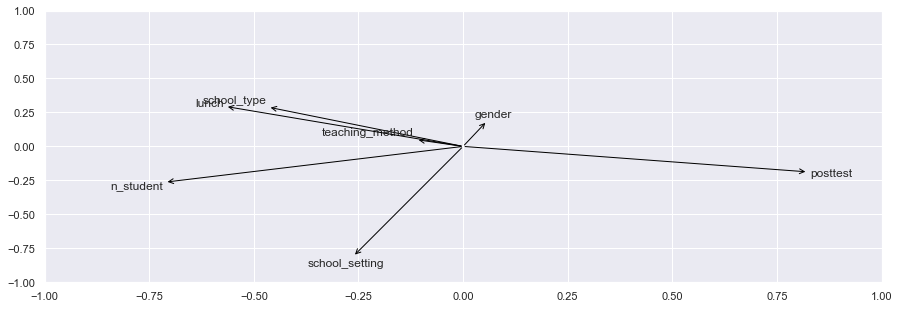

In [20]:
biplot(PCA(n_components=2, svd_solver='full'), df.drop(columns=['school']))

## Part 2: Hypothesis Testing

Next, we'll question whether the differences, of posttest scores, between some groups in the data, are significant. More accurately, we're going to use the **Cohen’s $d$ effect size** to determine the significancy, for the reason that other methods (t-test, mannwhitneyu test and more) just gave us odd results that weren't happy with.
Anyway, the **Cohen’s $d$ effect size** is mathematically denoted by:

<center> $d = \frac{\bar{x}_1 - \bar{x}_2}{s} $ : $\bar{x}_1, \bar{x}_2$ are the averages of each group, and </center>

<center> $s = \sqrt{\frac{(n_1-1) s_1^2 + (n_2-1) s_2^2}{n_1 + n_2}} $ : $s_1, s_2$ are the standard deviation of each group </center>

The value of $d$ should be interpreted with the following table:

| d | Effect Size |
| --- | --- |
| **0.01** | **Very Small** |
| **0.2** | **Small** |
| **0.5** | **Medium** |
| **0.8** | **Large** |
| **1.0** | **Very Large** |
| **2.0** | **Huge** |

More info about the method could be found [here](https://en.wikipedia.org/wiki/Effect_size#Difference_family:_Effect_sizes_based_on_differences_between_means).

In [21]:
pd.concat([cohens_d_test(df, 'posttest', 'gender', 'Gender Effect Size on posttest scores'), 
           cohens_d_test(df, 'posttest', 'lunch', 'Lunch Effect Size on posttest scores'), 
           cohens_d_test(df, 'posttest', 'school_type', 'School Type Effect Size on posttest scores')], axis=1)

Gender Effect Size on posttest scores  \
$E[x_1]$                                     67.0   
$E[x_2]$                                     67.2   
$s$                                         13.98   
$d$                                          0.01   
Effect Size                            Very Small   

            Lunch Effect Size on posttest scores  \
$E[x_1]$                                   74.38   
$E[x_2]$                                   57.48   
$s$                                         11.2   
$d$                                         1.51   
Effect Size                                 Huge   

            School Type Effect Size on posttest scores  
$E[x_1]$                                         75.96  
$E[x_2]$                                         64.02  
$s$                                              12.97  
$d$                                               0.92  
Effect Size                                 Very Large

In [22]:
# students that qualifies to free lunch and those that do not

## Part 3: Clusterring the Data


## Part 4: Classifing Students to a Level of Success

Next, we're gonna classify the students into certain levels of success, using the [Academic grading in the United States](https://en.wikipedia.org/wiki/Academic_grading_in_the_United_States), or more specifically, the ranking system that evenly distributes grades, as follows:

| Grade |percentage of students receiving grade |
| --- | --- |
| **A** | **Top 20%** |
| **B** | **Next 20%** |
| **C** | **Middle 20%** |
| **D** | **Next 20%** |
| **F** | **Bottom 20%** |

We're gonna try a few classifiers, with optimized hyperparameters (using bayesian optimization).

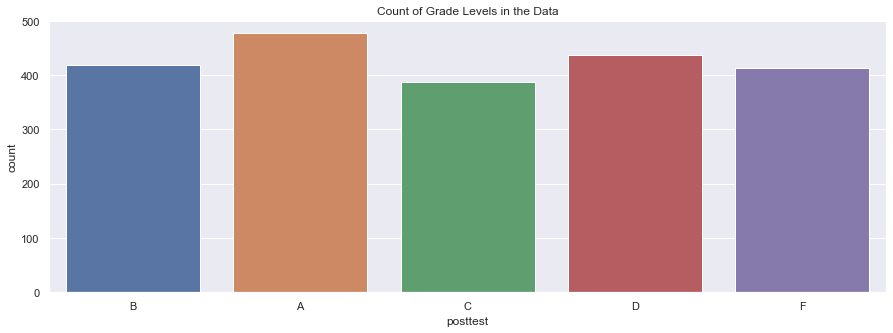

In [23]:
plt.title('Count of Grade Levels in the Data')
sns.countplot(rank(df['posttest']))
plt.show()

In [24]:
new_df = df.copy()
le = LabelEncoder()
y = new_df['posttest'].copy()
y = le.fit_transform(rank(y))
new_df = new_df.drop(columns=['posttest'])

In [25]:
cat_transformer = make_column_transformer((OrdinalEncoder(), new_df.select_dtypes(include=['object']).columns.to_list()), remainder='passthrough')

In [26]:
x_train, x_test, y_train, y_test = train_test_split(new_df, y, test_size=0.3, shuffle=True, stratify=y)

### Random Forest Classifier

In [27]:
sett = {'min_samples_split': {'space': (1e-10, 0.5), 'f': lambda _x: abs(_x)},
        'criterion': {'dtype': str, 'space': ['entropy', 'gini']},
        'n_estimators': {'dtype': int, 'space': (50, 400)}}

rfc = optimize(RandomForestClassifier, x_train, y_train, settings=sett, extra_steps=[('transform', cat_transformer)], 
              cv_params={'scoring': 'accuracy', 'cv': 3}, opt_params={'n_iter': 20})

|   iter    |  target   | criterion | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.4347   |  1.251    |  0.4075   |  81.75    |
|  2        |  0.4287   |  1.158    |  0.4114   |  300.8    |
|  3        |  0.5861   |  1.546    |  0.06374  |  219.4    |
|  4        |  0.4273   |  1.134    |  0.4238   |  322.6    |
|  5        |  0.4334   |  1.791    |  0.4364   |  231.6    |
|  6        |  0.562    |  0.2227   |  0.1054   |  215.4    |
|  7        |  0.71     |  2.0      |  1e-10    |  205.2    |
|  8        |  0.566    |  2.0      |  0.08787  |  199.7    |
|  9        |  0.4327   |  0.05548  |  0.4549   |  208.1    |
|  10       |  0.426    |  1.522    |  0.4195   |  319.9    |
|  11       |  0.4514   |  1.999    |  0.3508   |  204.3    |
|  12       |  0.4293   |  0.205    |  0.4793   |  62.4     |
|  13       |  0.4514   |  0.9124   |  0.3335   |  387.6    |
|  14       |  0.5399   |  1.989    |  0.1746   |  175.8    |
|  15   

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       143
           1       0.57      0.57      0.57       125
           2       0.61      0.65      0.63       116
           3       0.71      0.71      0.71       132
           4       0.86      0.82      0.84       124

    accuracy                           0.72       640
   macro avg       0.71      0.71      0.71       640
weighted avg       0.72      0.72      0.72       640



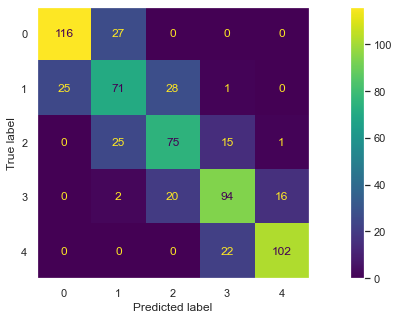

In [29]:
rfc = rfc.fit(x_train, y_train)
print(classification_report(y_test, rfc.predict(x_test)))
plt.grid()
plot_confusion_matrix(rfc, x_test, y_test, ax=plt.gca())
plt.show()

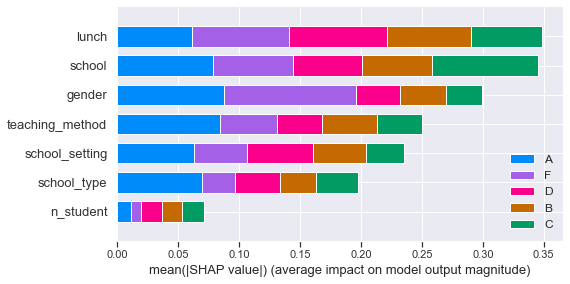

In [30]:
shap_values = shap.TreeExplainer(rfc.steps[1][1]).shap_values(rfc.steps[0][1].transform(x_test))
shap.summary_plot(shap_values, x_test, plot_type="bar", class_names=['A', 'B', 'C', 'D', 'F'])

### SVM Classifier

In [ ]:
sett = {'C': {'space': (1e-2, 50), 'f': lambda _x: abs(_x) + 1e-10},
       'kernel': {'dtype': str, 'space': ['linear', 'poly', 'rbf']},
       'degree': {'dtype': int, 'space': (3, 20)},
       #'gamma': {'space': (0.01, 1.0 - 1e-2), 'f': lambda _x: min(abs(_x), 1.0 - 1e-2)},
       'coef0': {'space': (0, 10)},
       'probability': {'dtype': int, 'space': (0, 0.5), 'f': lambda _x: True}}

svm = optimize(SVC, x_train, y_train, settings=sett, extra_steps=[('transform', cat_transformer)], 
               cv_params={'scoring': 'accuracy', 'cv': 3}, opt_params={'n_iter': 50})

|   iter    |  target   |     C     |   coef0   |  degree   |  kernel   | probab... |
-------------------------------------------------------------------------------------
|  1        |  0.5633   |  49.68    |  9.58     |  17.84    |  2.324    |  0.1799   |


### XGBoost Classifier

In [34]:
sett = {'n_estimators': {'dtype': int, 'space': (50, 400)},
        'reg_alpha': {'space': (1e-2, 10)},
        'reg_lambda ': {'space': (1e-2, 10)},
        'gamma': {'space': (1e-3, 1.0 - 1e-5), 'f': lambda _x: min(abs(_x), 1.0 - 1e-5)},
        'learning_rate': {'space': (1e-5, 10)},
    'objective ': {'dtype': str, 'space': ['multi:softmax', 'multi:softprob']},
       'booster': {'dtype': str, 'space': ['gbtree', 'gblinear', 'dart']}}

xgb = optimize(XGBClassifier, x_train, y_train, settings=sett, extra_steps=[('transform', cat_transformer)], 
               cv_params={'scoring': 'accuracy', 'cv': 5}, opt_params={'n_iter': 50})

|   iter    |  target   |  booster  |   gamma   | learni... | n_esti... | object... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.2726   |  0.7892   |  0.4148   |  6.001    |  116.3    |  1.284    |  0.477    |  6.765    |
|  2        |  0.219    |  1.255    |  0.4832   |  4.017    |  292.1    |  0.3583   |  0.8013   |  9.461    |
|  3        |  0.3649   |  0.7692   |  0.2413   |  2.26     |  73.55    |  1.984    |  6.121    |  5.464    |
|  4        |  0.4454   |  0.6865   |  0.3624   |  3.136    |  290.5    |  1.11     |  5.53     |  6.211    |
|  5        |  0.6544   |  0.4195   |  0.3652   |  0.6457   |  181.1    |  1.326    |  4.046    |  3.03     |
|  6        |  0.3074   |  2.174    |  0.9136   |  4.619    |  174.6    |  0.06753  |  6.476    |  3.001    |
|  7        |  0.2237   |  1.149    |  0.3071   |  0.3858   |  180.1    |  0.5666   |  4.322    |  3.961    |
|  8      

|  45       |  0.3744   |  0.5723   |  0.7951   |  3.549    |  203.3    |  1.318    |  0.5393   |  4.372    |
|  46       |  0.2479   |  2.929    |  0.038    |  5.755    |  154.1    |  0.9198   |  9.144    |  3.47     |
|  47       |  0.3778   |  2.526    |  0.3674   |  2.486    |  225.3    |  0.3115   |  3.206    |  5.453    |
|  48       |  0.2237   |  1.947    |  0.715    |  0.2969   |  284.9    |  0.0645   |  3.264    |  0.1416   |
|  49       |  0.6397   |  2.396    |  0.4996   |  1.11     |  286.6    |  1.36     |  6.015    |  6.915    |
|  50       |  0.2237   |  1.183    |  0.7927   |  0.6805   |  180.7    |  1.406    |  3.688    |  1.846    |
|  51       |  0.6631   |  2.749    |  0.1778   |  1.411    |  286.9    |  0.9595   |  5.648    |  8.045    |
|  52       |  0.6296   |  2.918    |  0.3762   |  0.9008   |  287.6    |  0.1205   |  7.135    |  6.275    |
|  53       |  0.6437   |  2.63     |  0.833    |  1.094    |  287.4    |  0.4132   |  5.654    |  7.119    |
|  54     

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       143
           1       0.60      0.56      0.58       125
           2       0.57      0.60      0.59       116
           3       0.68      0.66      0.67       132
           4       0.86      0.88      0.87       124

    accuracy                           0.71       640
   macro avg       0.70      0.71      0.70       640
weighted avg       0.71      0.71      0.71       640



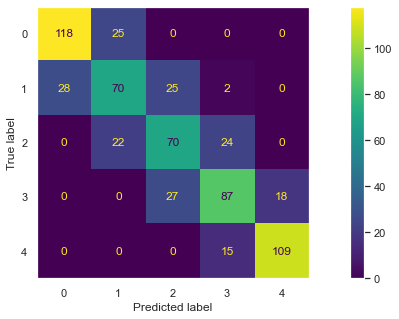

In [35]:
xgb = xgb.fit(x_train, y_train)
print(classification_report(y_test, xgb.predict(x_test)))
plt.grid()
plot_confusion_matrix(xgb, x_test, y_test, ax=plt.gca())
plt.show()

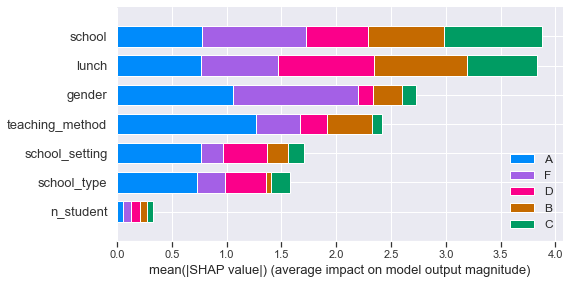

In [37]:
shap_values = shap.TreeExplainer(xgb.steps[1][1]).shap_values(xgb.steps[0][1].transform(x_test))
shap.summary_plot(shap_values, x_test, class_names=['A', 'B', 'C', 'D', 'F'])